In [1]:
# deepvar_backtest_save.py
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# --------- Config ----------
DATA_FOLDER = r"C:\Users\sohan\Downloads\archive (1)"  # <- update
OUTPUT_ROOT = "outputs_deepvar"
os.makedirs(OUTPUT_ROOT, exist_ok=True)

CONTEXT_LEN = 60
PRED_LEN = 10   # prediction horizon used by model (we will evaluate t+1 easily)
BATCH_SIZE = 64
EPOCHS = 50
LR = 1e-3
PATIENCE = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# --------- Utilities ----------
def rmse(y_true, y_pred): return math.sqrt(mean_squared_error(y_true, y_pred))
def mape(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    eps = 1e-9
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

# --------- Dataset ----------
class TimeSeriesDataset(Dataset):
    def __init__(self, series, context_len=60, prediction_len=10):
        self.mean = float(np.mean(series))
        self.std = float(np.std(series)) + 1e-6
        scaled = (series - self.mean) / self.std
        self.series = torch.tensor(scaled, dtype=torch.float32)
        self.context_len = context_len
        self.pred_len = prediction_len

    def __len__(self):
        return max(0, len(self.series) - self.context_len - self.pred_len + 1)

    def __getitem__(self, idx):
        x = self.series[idx: idx + self.context_len]
        y = self.series[idx + self.context_len: idx + self.context_len + self.pred_len]
        return x, y

# --------- Model ----------
class DeepVAR(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3, dropout=0.3, pred_len=10):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc_mu = nn.Linear(hidden_size, pred_len)
        self.fc_sigma = nn.Linear(hidden_size, pred_len)

    def forward(self, x):
        # x: (batch, context)
        x = x.unsqueeze(-1)  # -> (batch, context, 1)
        out, _ = self.lstm(x)
        h = out[:, -1, :]  # last hidden
        mu = self.fc_mu(h)
        sigma = torch.exp(self.fc_sigma(h)) + 1e-6
        return mu, sigma

# --------- Training ----------
def train_model(model, dataloader, epochs=50, lr=1e-3, patience=5, device=DEVICE):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)
    best_loss = float("inf")
    no_improve = 0
    best_state = None

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for xb, yb in dataloader:
            xb = xb.to(device)
            yb = yb.to(device)
            mu, sigma = model(xb)
            # Gaussian negative log-likelihood per sample
            loss = 0.5 * torch.log(2 * math.pi * sigma**2) + ((yb - mu)**2) / (2 * sigma**2)
            loss = loss.mean()
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / max(1, len(dataloader))
        scheduler.step(avg_loss)
        # print progress
        print(f" Epoch {epoch}/{epochs} — avg loss: {avg_loss:.6f}")
        if avg_loss < best_loss - 1e-8:
            best_loss = avg_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(" Early stopping.")
                break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

# --------- Backtesting (sliding) ----------
def backtest(series, model, context_len=60, pred_len=10, mean=0.0, std=1.0, device=DEVICE):
    model.to(device)
    model.eval()
    preds, trues, lowers, uppers = [], [], [], []
    n_steps = len(series) - context_len - pred_len + 1
    if n_steps <= 0:
        return np.empty((0, pred_len)), np.empty((0, pred_len)), np.empty((0, pred_len)), np.empty((0, pred_len))

    with torch.no_grad():
        for t in range(n_steps):
            context = torch.tensor(((series[t:t+context_len] - mean)/std), dtype=torch.float32).unsqueeze(0).to(device)
            mu, sigma = model(context)  # shapes (1, pred_len)
            mu = mu.cpu().numpy().flatten() * std + mean
            sigma = sigma.cpu().numpy().flatten() * std
            preds.append(mu)
            trues.append(series[t+context_len: t+context_len+pred_len])
            lowers.append(mu - 1.96*sigma)
            uppers.append(mu + 1.96*sigma)
    return np.array(preds), np.array(trues), np.array(lowers), np.array(uppers)

# --------- Plot helpers ----------
def save_static_plot(series, preds, lowers, uppers, out_path, title):
    plt.figure(figsize=(12,5))
    plt.plot(series, label="Actual", color="black", linewidth=1)
    # plot t+1 preds aligned to end part
    start = len(series) - len(preds)
    if len(preds) > 0:
        plt.plot(range(start, len(series)), preds[:,0], label="Forecast (t+1)", color="red")
        plt.fill_between(range(start, len(series)), lowers[:,0], uppers[:,0], color="red", alpha=0.2, label="95% CI")
    plt.title(title); plt.xlabel("Index"); plt.ylabel("Close"); plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200); plt.close()

def save_error_heatmap(preds, trues, out_path, title):
    if preds.size == 0:
        return
    errors = np.abs(preds - trues)  # shape (steps, pred_len)
    plt.figure(figsize=(10,5))
    sns.heatmap(errors.T, cmap="Reds", cbar=True)
    plt.title(title)
    plt.xlabel("Backtest Steps"); plt.ylabel("Prediction Horizon")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200); plt.close()

# --------- Main ----------
all_metrics = []
csv_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "*.csv")))
csv_files = [f for f in csv_files if "HEALTHCARE" not in os.path.basename(f).upper()]  # skip healthcare as requested

for filepath in csv_files:
    try:
        sector = os.path.splitext(os.path.basename(filepath))[0]
        print(f"\n=== Processing: {sector} ===")

        df = pd.read_csv(filepath)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').reset_index(drop=True)
        series = df['Close'].values.astype(float)

        # create dataset & dataloader
        dataset = TimeSeriesDataset(series, context_len=CONTEXT_LEN, prediction_len=PRED_LEN)
        if len(dataset) == 0:
            print(f" Skipping {sector}: series too short for context/prediction lengths.")
            continue
        dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

        # model
        model = DeepVAR(pred_len=PRED_LEN, hidden_size=128, num_layers=3, dropout=0.3)
        model = train_model(model, dataloader, epochs=EPOCHS, lr=LR, patience=PATIENCE)

        # backtest
        preds, trues, lowers, uppers = backtest(series, model, context_len=CONTEXT_LEN, pred_len=PRED_LEN,
                                               mean=dataset.mean, std=dataset.std, device=DEVICE)

        # compute horizon=1 metrics (t+1)
        if preds.size == 0:
            print(f" No predictions for {sector}.")
            continue
        y_pred_1 = preds[:, 0]
        y_true_1 = trues[:, 0]
        mae1 = mean_absolute_error(y_true_1, y_pred_1)
        rmse1 = rmse(y_true_1, y_pred_1)
        mape1 = mape(y_true_1, y_pred_1)
        r21 = r2_score(y_true_1, y_pred_1)

        # Save outputs
        out_dir = os.path.join(OUTPUT_ROOT, sector)
        os.makedirs(out_dir, exist_ok=True)
        np.save(os.path.join(out_dir, "preds.npy"), preds)
        np.save(os.path.join(out_dir, "trues.npy"), trues)
        np.save(os.path.join(out_dir, "lower95.npy"), lowers)
        np.save(os.path.join(out_dir, "upper95.npy"), uppers)

        # save model checkpoint
        torch.save(model.state_dict(), os.path.join(out_dir, "model_checkpoint.pt"))

        # save per-sector metrics csv
        metrics_df = pd.DataFrame([{
            "sector": sector,
            "mae_t+1": float(mae1),
            "rmse_t+1": float(rmse1),
            "mape_t+1": float(mape1),
            "r2_t+1": float(r21),
            "n_backtest_steps": int(preds.shape[0])
        }])
        metrics_df.to_csv(os.path.join(out_dir, "metrics.csv"), index=False)

        # aggregate
        all_metrics.append({
            "sector": sector,
            "mae_t+1": float(mae1),
            "rmse_t+1": float(rmse1),
            "mape_t+1": float(mape1),
            "r2_t+1": float(r21),
            "n_backtest_steps": int(preds.shape[0])
        })

        # save visuals
        save_static_plot(series, preds, lowers, uppers, os.path.join(out_dir, "forecast_static.png"),
                         title=f"{sector} — Static Forecast (t+1) with 95% CI")
        save_error_heatmap(preds, trues, os.path.join(out_dir, "error_heatmap.png"),
                           title=f"{sector} — Absolute Error Heatmap")

        print(f" Saved outputs to {out_dir}")

    except Exception as e:
        print(f" ERROR processing {filepath}: {e}")
        continue

# master CSV
if len(all_metrics) > 0:
    master_df = pd.DataFrame(all_metrics)
    master_df.to_csv(os.path.join(OUTPUT_ROOT, "all_metrics_deepvar.csv"), index=False)
    print(f"\nMaster metrics saved to {os.path.join(OUTPUT_ROOT, 'all_metrics_deepvar.csv')}")
else:
    print("No metrics to save.")



=== Processing: NIFTY 50_cleaned ===
 Epoch 1/50 — avg loss: 0.135326
 Epoch 2/50 — avg loss: -1.009657
 Epoch 3/50 — avg loss: -1.229979
 Epoch 4/50 — avg loss: -1.329504
 Epoch 5/50 — avg loss: -1.333901
 Epoch 6/50 — avg loss: -1.380680
 Epoch 7/50 — avg loss: -1.310484
 Epoch 8/50 — avg loss: -1.333880
 Epoch 9/50 — avg loss: -1.430371
 Epoch 10/50 — avg loss: -1.390484
 Epoch 11/50 — avg loss: -1.386768
 Epoch 12/50 — avg loss: -1.474253
 Epoch 13/50 — avg loss: -1.498053
 Epoch 14/50 — avg loss: -1.420822
 Epoch 15/50 — avg loss: -1.497800
 Epoch 16/50 — avg loss: -1.453190
 Epoch 17/50 — avg loss: -1.544030
 Epoch 18/50 — avg loss: -1.543331
 Epoch 19/50 — avg loss: -1.540037
 Epoch 20/50 — avg loss: -1.549661
 Epoch 21/50 — avg loss: -1.570822
 Epoch 22/50 — avg loss: -1.587114
 Epoch 23/50 — avg loss: -1.573883
 Epoch 24/50 — avg loss: -1.580432
 Epoch 25/50 — avg loss: -1.548398
 Epoch 26/50 — avg loss: -1.613685
 Epoch 27/50 — avg loss: -1.622321
 Epoch 28/50 — avg loss: -1

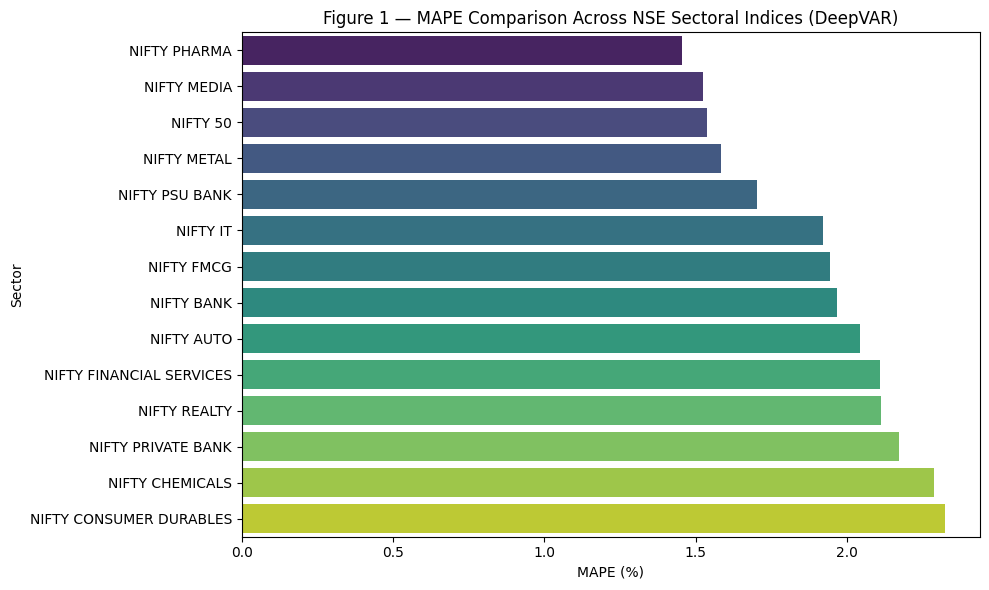

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("outputs_deepvar/all_metrics_deepvar.csv")
df['sector'] = df['sector'].str.replace('_cleaned','')
df = df.sort_values('mape_t+1')

plt.figure(figsize=(10,6))
sns.barplot(x='mape_t+1', y='sector', data=df, palette='viridis')
plt.xlabel("MAPE (%)")
plt.ylabel("Sector")
plt.title("Figure 1 — MAPE Comparison Across NSE Sectoral Indices (DeepVAR)")
plt.tight_layout()
plt.savefig("DeepVAR_MAPE_plot.png", dpi=300)
plt.show()


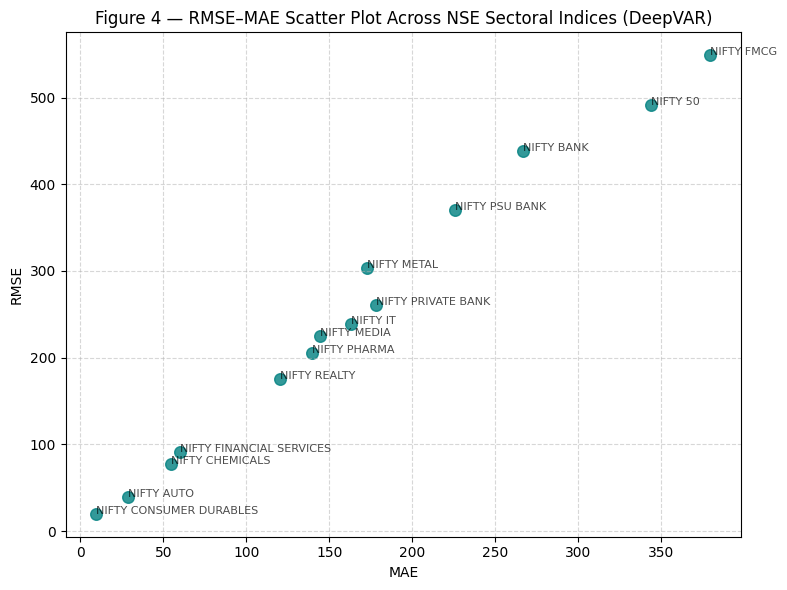

In [3]:
plt.figure(figsize=(8,6))
plt.scatter(df['mae_t+1'], df['rmse_t+1'], s=70, c='teal', alpha=0.8)
for i, txt in enumerate(df['sector']):
    plt.annotate(txt, (df['mae_t+1'][i], df['rmse_t+1'][i]), fontsize=8, alpha=0.7)
plt.xlabel("MAE")
plt.ylabel("RMSE")
plt.title("Figure 4 — RMSE–MAE Scatter Plot Across NSE Sectoral Indices (DeepVAR)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("DeepVAR_RMSE_MAE_Scatter.png", dpi=300)
plt.show()


In [2]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu
  Obtaining dependency information for torch from https://download.pytorch.org/whl/cpu/torch-2.8.0%2Bcpu-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for torchvision from https://download.pytorch.org/whl/cpu/torchvision-0.23.0%2Bcpu-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for torchaudio from https://download.pytorch.org/whl/cpu/torchaudio-2.8.0%2Bcpu-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for sympy>=1.13.3 from https://download.pytorch.org/whl/sympy-1.13.3-py3-none-any.whl.metadata
  Obtaining dependency information for jinja2 from https://download.pytorch.org/whl/Jinja2-3.1.4-py3-none-any.whl.metadata
Discarding https://download.pytorch.org/whl/Jinja2-3.1.4-py3-none-any.whl#sha256=bc5dd2abb727a5319567b7a813e6a2e7318c39f4f487cfe6c89c6f9c7d25197d (from https://download.pytorch.org/whl/cpu/jinja2/): Requested jinja2 from https://download.pytorch.o


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\sohan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


   -------- ------------------------------- 131.1/619.4 MB 1.1 MB/s eta 0:07:35
   -------- ------------------------------- 131.2/619.4 MB 1.1 MB/s eta 0:07:35
   -------- ------------------------------- 131.2/619.4 MB 1.1 MB/s eta 0:07:35
   -------- ------------------------------- 131.2/619.4 MB 1.1 MB/s eta 0:07:36
   -------- ------------------------------- 131.3/619.4 MB 1.1 MB/s eta 0:07:35
   -------- ------------------------------- 131.4/619.4 MB 1.1 MB/s eta 0:07:34
   -------- ------------------------------- 131.4/619.4 MB 1.1 MB/s eta 0:07:35
   -------- ------------------------------- 131.4/619.4 MB 1.1 MB/s eta 0:07:37
   -------- ------------------------------- 131.4/619.4 MB 1.1 MB/s eta 0:07:37
   -------- ------------------------------- 131.5/619.4 MB 1.1 MB/s eta 0:07:40
   -------- ------------------------------- 131.6/619.4 MB 1.1 MB/s eta 0:07:37
   -------- ------------------------------- 131.6/619.4 MB 1.1 MB/s eta 0:07:37
   -------- ----------------------------